# SVM for classification

### Importing Libraries for running the code and plotting the results

In [121]:
import os
import numpy as np
import pandas as pd
import matplotlib.colors
import matplotlib.pyplot as plt
np.random.seed(102)

### Importing sklearn tools and methods to proof the algorithm is working correctly

In [122]:
from sklearn.svm import SVC 
from sklearn.utils import resample 
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, plot_confusion_matrix

## Dataset Preparation

In [152]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path, header=1)
    print(df)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

## Importing the data

In [153]:

def main():

    # read dataset from csv file
    data_name = "messidor_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    # Train and test set
    # kf = KFold(n_splits=10)
    # res_list = []
    # for train_index, test_index in kf.split(data_X):
    #     train_X, train_y = data_X[train_index,:], data_y[train_index]
    #     test_X, test_y = data_X[test_index,:], data_y[test_index]
    return data_X, data_y



In [167]:

data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "messidor_classification.csv")
df = pd.read_csv(data_path, header=0)
df['Class'] = df['Class'].str.split("b'").str[1]
df['Class'] = df['Class'].str.split("'").str[0]
df['Class'] = df['Class'].astype(int)
print(df['Class'])

0       0
1       0
2       1
3       0
4       1
       ..
1146    0
1147    0
1148    0
1149    1
1150    0
Name: Class, Length: 1151, dtype: int8


## Data Preprocessing

In order to improve our performance, we want to make sure that the data we are dealing with is good. This means, there is no missing data, we are aware of the data types, and we fix possible mistakes. 

In [142]:
x, y = main()
# dfx = np.array(dfx, dtype=np.float32)
# dfy = np.array(dfy, dtype=np.int64)
dfx = pd.DataFrame(x) 
dfy = pd.DataFrame(y) 

In [143]:
# dfx.dtypes
dfx.rename({0 : 'col_0',
            1 : 'col_1',
            2 : 'col_2',
            3 : 'col_3',
            4 : 'col_4',
            5 : 'col_5',
            6 : 'col_6',
            7 : 'col_7',
            8 : 'col_8',
            9 : 'col_9',
            10: 'col_10',
            11: 'col_11',
            12: 'col_12',
            13: 'col_13',
            14: 'col_14',
            15: 'col_15',
            16: 'col_16',
            17: 'col_17',
            18: 'col_18'}, axis='columns', inplace=True)
dfy.rename({0:'y'}, axis='columns', inplace=True) 
dfy.head()


,y
0,1
1,1
2,1
3,1
4,1


## Implementation of SVM

We choose the Gaussian kernel (RBF kernel) for SVM. For any $x_i, x_j \in\mathbb{R}^d$, we define
$$
\kappa(x_i, x_j) = \exp \bigl( - \|x_i - x_j\|^2 / (2 \sigma^2) \bigr)
$$ 
where $\sigma > 0$ is the width of the Gaussian kernel.

In [127]:
class SVM():
    '''
    This is a class for support vector machine.
    
    The class contains the hyper-parameters such as $C$ and the kernel bandwidth $\sigma$. It also contains 
    the alpha vector, the tolerance for prediction error and the maximum number of iteration.
    
    It contains the functions for calculating the kernel matrix, fitting the model to estimate alpha and b 
    with SMO algorithm, making predictions and other fundamental functions.
    
    Attributes:
        C (positive number)         - the hyperparameter for SVM algorithm
        sigma (positive number)     - the kernel bandwidth $\sigma$ of Gaussian kernel 
        toler (positive number)     - the threshold value of prediction error. If the prediction error of 
                                      a sample is larger than this value, the corresponding alpha_i will be 
                                      probably updated.
        maxIter (positive integer)  - the maximum number of iteration to search a pair of alpha's to update
        alphas (vector, num_samples)- the alpha vector in the dual problem 
        b (number)                  - the bias b
    '''
    
    def __init__(self, C = 1, sigma = 1, toler = 0.01, maxIter = 100):
        self.C = C
        self.sigma = sigma
        self.toler = toler
        self.maxIter = maxIter
        self.alphas = 0
        self.b = 0
        
    def rbfkernel(self, X, Y):
        '''
        Calculate the kernel matrix whose (i,j)-th entry is $k(X[i,:], Y[j,:])$.
        '''
        m = X.shape[0]
        n = Y.shape[0]
        K = np.zeros(shape=(m, n))
        for i in range(m):
            for j in range(n):
                K[i, j] = np.sum((X[i,:] - Y[j,:])**2)
        K = np.exp(-K / (2 * self.sigma**2))
        return K

    def selectJrand(self, i, m):
        '''
        Randomly choose an index $j\neq i$ from 0 to m-1
        '''
        j = i 
        while (j == i):
            j = int(np.random.uniform(0, m))
        return j


    def clipAlpha(self, aj, H, L):
        '''
        Clip the vale aj by the lower bound L and upper bound H
        '''
        if aj > H:
            aj = H
        if L > aj:
            aj = L
        return aj


    def fit(self, X_train, y_train):
        '''
        estimate the alphas vector and bias in the SVM model
        
        Args: 
            X_train (matrix, num_train*num_features): features of training samples
            y_train (vector, num_train): label of training samples, each label is either -1 or 1
            
        Returns:
            self.b (a number)                 : the bias
            self.alphas (vector, num_features): the alpha vector 
        ''' 
        K_train = self.rbfkernel(X_train, X_train)
        self.X_train = X_train
        self.y_train = y_train
        m = K_train.shape[0]
        self.alphas = np.zeros((m, ))
        num_iter = 0
        while (num_iter < self.maxIter):
            alphaPairsChanged = 0
            # optimize for each data vector (with kernel trick)
            for i in range(m):   
                fXi = (self.alphas * y_train) @ K_train[i, :] + self.b
                # if checks if an example violates KKT conditions
                Ei = fXi - y_train[i]
                if ((y_train[i] * Ei < -self.toler) and (self.alphas[i] < self.C)) \
                       or ((y_train[i] * Ei > self.toler) and (self.alphas[i] > 0)):
                    j = self.selectJrand(i, m)
                    fXj = (self.alphas * y_train) @ K_train[j, :] + self.b
                    Ej = fXj - y_train[j]
                    alphaJold = self.alphas[j].copy()
                    alphaIold = self.alphas[i].copy()
                    if (y_train[j] != y_train[i]):
                        L = max(0, self.alphas[i] - self.alphas[j])
                        H = min(self.C, self.C + self.alphas[i] - self.alphas[j])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])
                    if L == H:
                        continue
                    eta = 2.0 * K_train[j, i] - K_train[j, j] - K_train[i, i]
                    if eta >= 0:
                        continue
                    self.alphas[i] += y_train[i] * (Ei - Ej) / eta
                    self.alphas[i] = self.clipAlpha(self.alphas[i], H, L)
                    if (abs(self.alphas[i] - alphaIold) < 0.00001):
                        continue
                    # update i by the same amount as j, the direction depends on y[i] and y[j]
                    self.alphas[j] += y_train[i] * y_train[j] * (alphaIold - self.alphas[i])
                    # update self.b
                    b1 = self.b - Ej - y_train[j] * (self.alphas[j] - alphaJold) * K_train[
                        j, j] - y_train[i] * (self.alphas[i] - alphaIold) * K_train[j, i]
                    b2 = self.b - Ei - y_train[j] * (self.alphas[j] - alphaJold) * K_train[
                        j, i] - y_train[i] * (self.alphas[i] - alphaIold) * K_train[i, i]
                    if (0 < self.alphas[j]) and (self.C > self.alphas[j]): self.b = b1
                    elif (0 < self.alphas[i]) and (self.C > self.alphas[i]): self.b = b2
                    else: self.b = (b1 + b2) / 2.0
                    alphaPairsChanged += 1
            if (alphaPairsChanged == 0): num_iter += 1
            else: num_iter = 0
        return self.b, self.alphas


    def predict(self,X_test):
        '''
        predict the label of test samples
        Args:
            X_test(matrix, num_test*num_features): features of test samples
        Returns:
            y_hat(vector, num_test): the predicted label of test samples, each label is either -1 or 1
        '''
        K_test = self.rbfkernel(self.X_train, X_test)
        f = K_test.T @ (self.alphas * self.y_train) + self.b
        y_hat = np.sign(f)
        return y_hat

## Run SVM on the dataset

In [128]:
def t_t():
    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(main()[0], main()[1], test_size=0.33, random_state=100)
    return train_X, test_X, train_y, test_y

In [129]:
clf_svm = SVC(random_state=42)
clf_svm.fit(t_t()[0], t_t()[2])

SVC(random_state=42)

c:\Users\josep\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


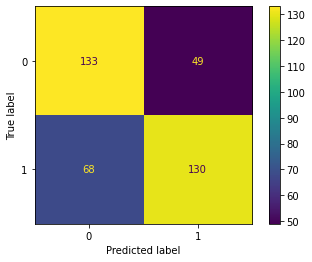

In [130]:
plot_confusion_matrix(clf_svm,t_t()[1],  t_t()[3], values_format='d')

In [131]:
param_grid = [{'C':[0.5, 1, 10, 100], 'gamma': ['scale', 1, 0.1, 0.01, 0.001], 'kernel': ['rbf'] }]

In [132]:
from sklearn.model_selection import GridSearchCV

optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv = 5,
                             scoring = 'accuracy' )

optimal_params.fit(t_t()[0], t_t()[2])
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [136]:
clf_svm = SVC(random_state=42, C = 100, gamma=0.01)
clf_svm.fit(t_t()[0], t_t()[2])

SVC(C=100, gamma=0.01, random_state=42)

c:\Users\josep\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


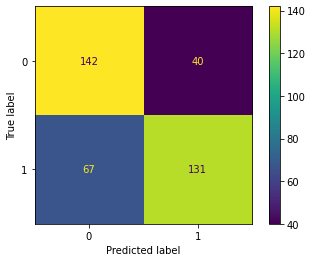

In [137]:
plot_confusion_matrix(clf_svm,t_t()[1],  t_t()[3], values_format='d')

In [ ]:
pca = PCA()

In [133]:
def run():
    # running the model and getting the accuracy
    model_SVM = SVM(C = 100, sigma = 2, toler=0.001, maxIter=40)
    b, alphas = model_SVM.fit(t_t()[0], t_t()[2])
    y_test_hat = model_SVM.predict(t_t()[1])
    accuracy = np.mean(y_test_hat == t_t()[3])
    print("The accuracy of SVM is:", accuracy)

In [120]:
run()

The accuracy of SVM is: 0.010526315789473684


In [134]:
# def loadDataSet(dataset_path):
#     data = pd.read_table(dataset_path, header=None)
#     data_X, data_y = data.iloc[:, :-1], data.iloc[:, -1]
#     data_X = np.array(data_X, dtype=np.float32)
#     data_y = np.array(data_y, dtype=np.int64)
#     data_y[data_y == 0] = -1
#     return data_X, data_y

In [135]:
# # read the data
# X_train, y_train = loadDataSet("horseColicTraining.txt") 
# X_test, y_test = loadDataSet("horseColicTest.txt")
# # normalize
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

## New attempt with some data and implementation


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, f1_score, accuracy_score, recall_score, precision_score, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from scipy.stats import randint as sp_randint
import warnings
warnings.filterwarnings('ignore')

data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "messidor_classification.csv")
df = pd.read_csv(data_path, header=0)

print(df.head())

     0    1     2     3     4     5     6     7          8          9  \
0  1.0  1.0  22.0  22.0  22.0  19.0  18.0  14.0  49.895756  17.775994   
1  1.0  1.0  24.0  24.0  22.0  18.0  16.0  13.0  57.709936  23.799994   
2  1.0  1.0  62.0  60.0  59.0  54.0  47.0  33.0  55.831441  27.993933   
3  1.0  1.0  55.0  53.0  53.0  50.0  43.0  31.0  40.467228  18.445954   
4  1.0  1.0  44.0  44.0  44.0  41.0  39.0  27.0  18.026254   8.570709   

          10        11        12        13        14        15        16  \
0   5.270920  0.771761  0.018632  0.006864  0.003923  0.003923  0.486903   
1   3.325423  0.234185  0.003903  0.003903  0.003903  0.003903  0.520908   
2  12.687485  4.852282  1.393889  0.373252  0.041817  0.007744  0.530904   
3   9.118901  3.079428  0.840261  0.272434  0.007653  0.001531  0.483284   
4   0.410381  0.000000  0.000000  0.000000  0.000000  0.000000  0.475935   

         17   18 Class  
0  0.100025  1.0  b'0'  
1  0.144414  0.0  b'0'  
2  0.128548  0.0  b'1'  
3  0

In [2]:
# Change column names so that we can keepy better track of each attribute.
col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
             ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
             'euc_dist','diam_opt_disc','AM/FM','class_label']
df.columns = col_names

In [3]:
# Extract binary class in numeric form (1 or 0) from string.
df.class_label = df.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))

In [4]:
# Check for high correlation among features
df.corr()

,qual_assess,pre_screen,MA_detection_.5,MA_detection_.6,MA_detection_.7,MA_detection_.8,MA_detection_.9,MA_detection_1.0,exudate_detection_.3,exudate_detection_.4,exudate_detection_.5,exudate_detection_.6,exudate_detection_.7,exudate_detection_.8,exudate_detection_.9,exudate_detection_1.0,euc_dist,diam_opt_disc,AM/FM,class_label
qual_assess,1.000000,-0.017611,0.035576,0.035929,0.033395,0.036506,0.034817,0.031889,0.063597,0.063061,0.044449,0.027656,0.013336,0.011864,0.012695,0.012289,-0.021943,-0.067325,-0.051723,0.062816
pre_screen,-0.017611,1.000000,0.053300,0.054839,0.053056,0.059063,0.060557,0.060152,0.062930,0.052453,0.053534,0.041607,0.015900,0.018950,0.023268,0.023861,0.004751,-0.079577,0.010782,-0.076925
MA_detection_.5,0.035576,0.053300,1.000000,0.996177,0.985730,0.963149,0.925274,0.859620,-0.229653,-0.103047,-0.044650,0.103035,0.134464,0.142917,0.196550,0.208422,0.000001,0.033992,-0.344317,0.292603
MA_detection_.6,0.035929,0.054839,0.996177,1.000000,0.994221,0.977030,0.944504,0.883511,-0.244704,-0.115253,-0.058364,0.086486,0.117895,0.124198,0.172633,0.185645,0.001953,0.034714,-0.360716,0.266338
MA_detection_.7,0.033395,0.053056,0.985730,0.994221,1.000000,0.991821,0.968676,0.916198,-0.283188,-0.139111,-0.086595,0.057769,0.094513,0.098859,0.140774,0.156441,0.000387,0.030396,-0.389384,0.234691
MA_detection_.8,0.036506,0.059063,0.963149,0.977030,0.991821,1.000000,0.988294,0.947860,-0.309950,-0.160011,-0.109946,0.029768,0.067477,0.069797,0.102638,0.119405,0.001520,0.016854,-0.411806,0.197511
MA_detection_.9,0.034817,0.060557,0.925274,0.944504,0.968676,0.988294,1.000000,0.974577,-0.349811,-0.197279,-0.152578,-0.020469,0.022265,0.024959,0.050579,0.070735,-0.001725,0.010961,-0.437036,0.161631
MA_detection_1.0,0.031889,0.060152,0.859620,0.883511,0.916198,0.947860,0.974577,1.000000,-0.375506,-0.223681,-0.181197,-0.058153,-0.012400,-0.012175,0.006868,0.031520,-0.002557,-0.011607,-0.435127,0.127861
exudate_detection_.3,0.063597,0.062930,-0.229653,-0.244704,-0.283188,-0.309950,-0.349811,-0.375506,1.000000,0.767091,0.763409,0.486606,0.163915,0.132227,0.114722,0.084682,-0.086155,-0.086474,0.390304,0.058015
exudate_detection_.4,0.063061,0.052453,-0.103047,-0.115253,-0.139111,-0.160011,-0.197279,-0.223681,0.767091,1.000000,0.919589,0.624537,0.257159,0.216127,0.181431,0.139196,-0.128990,-0.090721,0.291554,0.000479


<AxesSubplot:>

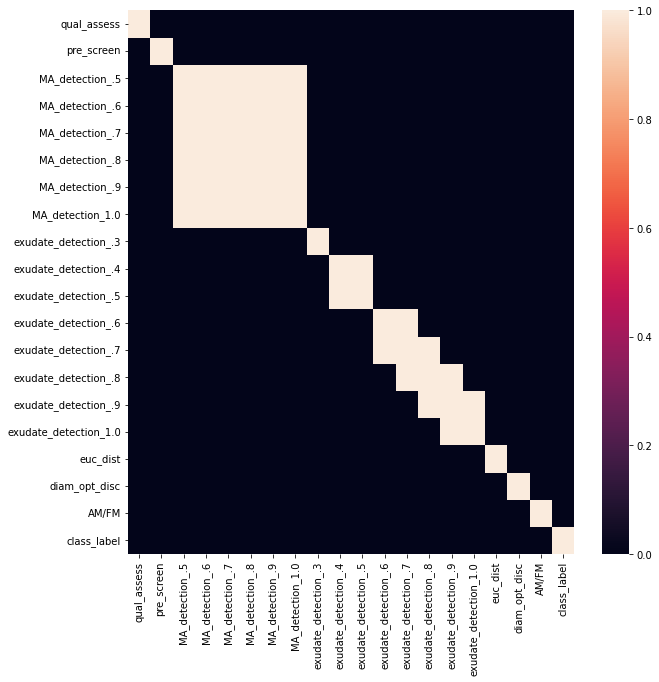

In [5]:
# Heatmap of correlation above 0.8.
fig = plt.figure(figsize = (10,10))
sns.heatmap(abs(df.corr()) > .8)

In [6]:
# Since we will need to drop all but 1 of the MA features, we will try 6 different datasets, each keeping a
# different MA feature. Initialize these data frames by backing copy of original.

df_MA5 = df.copy()
df_MA6 = df.copy()
df_MA7 = df.copy()
df_MA8 = df.copy()
df_MA9 = df.copy()
df_MA10 = df.copy()

In [7]:
# For each new dataframe, specify the MA columns we want to drop (all but 1). Also drop every other exudate
# detection column for all datasets. This will eliminate correlation among exudate features.

drop_5 = ['MA_detection_1.0','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']
drop_6 = ['MA_detection_.5','MA_detection_1.0','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']
drop_7 = ['MA_detection_.5','MA_detection_.6','MA_detection_1.0','MA_detection_.8',
             'MA_detection_.9', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']
drop_8 = ['MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_1.0',
             'MA_detection_.9', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']
drop_9 = ['MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_1.0', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']
drop_10 = ['MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
             'MA_detection_.9', 'exudate_detection_.4','exudate_detection_.6','exudate_detection_.8',
                  'exudate_detection_1.0']

In [8]:
# Drop appropriate columns to create these dataframes.

df_MA5.drop(columns = drop_5, inplace = True)
df_MA6.drop(columns = drop_6, inplace = True)
df_MA7.drop(columns = drop_7, inplace = True)
df_MA8.drop(columns = drop_8, inplace = True)
df_MA9.drop(columns = drop_9, inplace = True)
df_MA10.drop(columns = drop_10, inplace = True)

In [9]:
# Check to make sure the desired result is achieved. 

print(df_MA5.columns)
print(df_MA6.columns)
print(df_MA7.columns)
print(df_MA8.columns)
print(df_MA9.columns)
print(df_MA10.columns)

Index(['qual_assess', 'pre_screen', 'MA_detection_.5', 'exudate_detection_.3',
       'exudate_detection_.5', 'exudate_detection_.7', 'exudate_detection_.9',
       'euc_dist', 'diam_opt_disc', 'AM/FM', 'class_label'],
      dtype='object')
Index(['qual_assess', 'pre_screen', 'MA_detection_.6', 'exudate_detection_.3',
       'exudate_detection_.5', 'exudate_detection_.7', 'exudate_detection_.9',
       'euc_dist', 'diam_opt_disc', 'AM/FM', 'class_label'],
      dtype='object')
Index(['qual_assess', 'pre_screen', 'MA_detection_.7', 'exudate_detection_.3',
       'exudate_detection_.5', 'exudate_detection_.7', 'exudate_detection_.9',
       'euc_dist', 'diam_opt_disc', 'AM/FM', 'class_label'],
      dtype='object')
Index(['qual_assess', 'pre_screen', 'MA_detection_.8', 'exudate_detection_.3',
       'exudate_detection_.5', 'exudate_detection_.7', 'exudate_detection_.9',
       'euc_dist', 'diam_opt_disc', 'AM/FM', 'class_label'],
      dtype='object')
Index(['qual_assess', 'pre_screen', 

<AxesSubplot:>

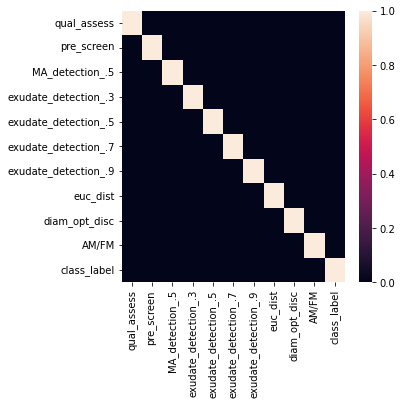

In [10]:
# Check the correlation of each dataframe. 

fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA5.corr()) > .8)

<AxesSubplot:>

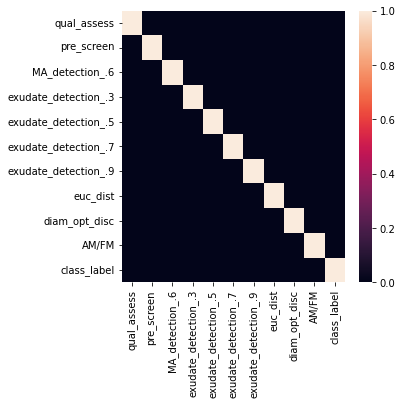

In [11]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA6.corr()) > .8)

<AxesSubplot:>

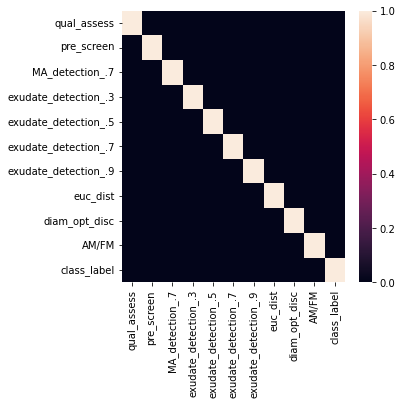

In [12]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA7.corr()) > .8)

<AxesSubplot:>

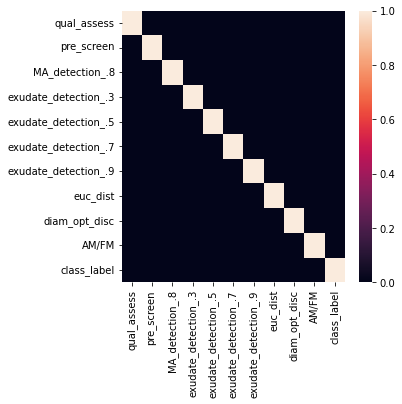

In [13]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA8.corr()) > .8)

<AxesSubplot:>

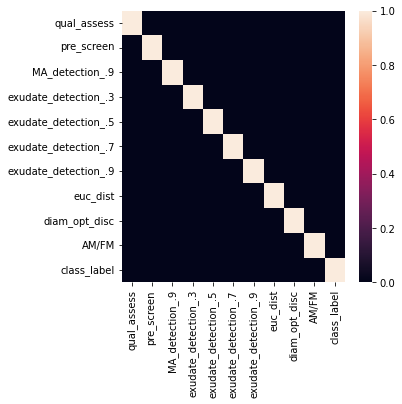

In [14]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA9.corr()) > .8)

<AxesSubplot:>

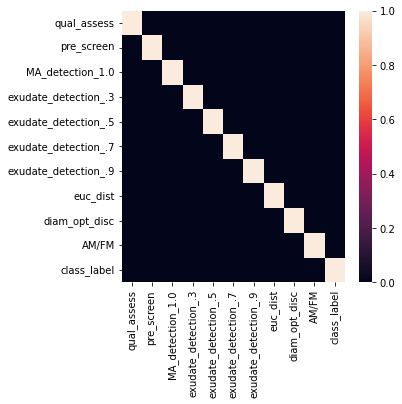

In [15]:
fig = plt.figure(figsize = (5,5))
sns.heatmap(abs(df_MA10.corr()) > .8)

# Prepare data for classification.

In [16]:
# Divide each new dataframe between variables and target. 

X = df.iloc[:,0:-1]
y = df.class_label

X_MA5 = df_MA5.iloc[:,0:-1]
y_MA5 = df_MA5.class_label

X_MA6 = df_MA6.iloc[:,0:-1]
y_MA6 = df_MA6.class_label

X_MA7 = df_MA7.iloc[:,0:-1]
y_MA7 = df_MA7.class_label

X_MA8 = df_MA8.iloc[:,0:-1]
y_MA8 = df_MA8.class_label

X_MA9 = df_MA9.iloc[:,0:-1]
y_MA9 = df_MA9.class_label

X_MA10 = df_MA10.iloc[:,0:-1]
y_MA10 = df_MA10.class_label

In [17]:
# Perform a test-train split for each dataframe.

X_train_MA5, X_test_MA5, y_train_MA5, y_test_MA5 = train_test_split(X_MA5,y_MA5, 
                                                                    test_size = .2, 
                                                                    random_state = 27,
                                                                    stratify = y_MA5)

X_train_MA6, X_test_MA6, y_train_MA6, y_test_MA6 = train_test_split(X_MA6,y_MA6, 
                                                                    test_size = .2, 
                                                                    random_state = 27,
                                                                    stratify = y_MA6)

X_train_MA7, X_test_MA7, y_train_MA7, y_test_MA7 = train_test_split(X_MA7,y_MA7, 
                                                                    test_size = .2, 
                                                                    random_state = 27,
                                                                    stratify = y_MA7)

X_train_MA8, X_test_MA8, y_train_MA8, y_test_MA8 = train_test_split(X_MA8,y_MA8, 
                                                                    test_size = .2, 
                                                                    random_state = 27,
                                                                    stratify = y_MA8)

X_train_MA9, X_test_MA9, y_train_MA9, y_test_MA9 = train_test_split(X_MA9,y_MA9, 
                                                                    test_size = .2, 
                                                                    random_state = 27,
                                                                    stratify = y_MA9)

X_train_MA10, X_test_MA10, y_train_MA10, y_test_MA10 = train_test_split(X_MA10,y_MA10, 
                                                                    test_size = .2, 
                                                                    random_state = 27,
                                                                    stratify = y_MA10)

In [18]:
# Create a baseline classifier 

dummy = DummyClassifier(strategy='most_frequent', random_state=13).fit(X, y)
dummy_predict = dummy.predict(X)

print('Test Accuracy score: ', accuracy_score(y, dummy_predict))
print('Test F1 score: ', f1_score(y, dummy_predict))

Test Accuracy score:  0.5308427454387489
Test F1 score:  0.6935300794551646


In [19]:
baseline_accuracy = accuracy_score(y, dummy_predict)

In [20]:
# Create dictionaries containing all train sets and all test sets respectively. 

train_sets = {'MA=.5_train':(X_train_MA5,y_train_MA5),
              'MA=.6_train':(X_train_MA6,y_train_MA6),
              'MA=.7_train':(X_train_MA7,y_train_MA7),
              'MA=.8_train':(X_train_MA8,y_train_MA8),
              'MA=.9_train':(X_train_MA9,y_train_MA9),
              'MA=1.0_train':(X_train_MA10,y_train_MA10)}

test_sets = {'MA=.5_test':(X_test_MA5,y_test_MA5),
             'MA=.6_test':(X_test_MA6,y_test_MA6),
             'MA=.7_test':(X_test_MA7,y_test_MA7),
             'MA=.8_test':(X_test_MA8,y_test_MA8),
             'MA=.9_test':(X_test_MA9,y_test_MA9),
             'MA=1.0_test':(X_test_MA10,y_test_MA10)}

In [21]:
# Create a column transformer object to incorporate into pipeline. This object will scale numerical values and leave
# categorical encoded variables untouched. 
preprocess_dict = {}
for key, val in train_sets.items():
    numerical = list(val[0].iloc[:,2:9].columns)
    preprocess_dict[key+'_scaled'] = make_column_transformer((StandardScaler(),numerical),
                                                            remainder = 'passthrough')
    
    

In [22]:
# For each dataframe, each keeping a different MA detection feature, perform a SVM pipeline.
# Pipeline scales numerical features, performs a PCA and SVM classification. A Grid Search with 5-fold 
# cross validation takes the in the pipeline object to optimize the classifer trying various hyperparameters
# and PCA components. Optimal model, best parameters, and best accuracy will be added to a dictionary. 

SVM_best_scores = {}

for key, val in train_sets.items():
    preprocess = preprocess_dict[key+'_scaled']
    model = make_pipeline(preprocess, SVC())
    params = {
              
              'svc__C': [.01,.01,.1,1,10,100,1000],
              'svc__gamma':['auto',.0001,.001,.01,.1,1,10,100], 
              'svc__class_weight':['balanced',None]
              }

    search_svm = GridSearchCV(estimator = model, param_grid = params,
                     cv = 5, return_train_score = True,
                      n_jobs = -1)

    search_svm.fit(val[0], val[1])
    SVM_best_scores[key] = {'model':search_svm, 'best_params':search_svm.best_params_,
                           'best_score':search_svm.best_score_}
    

In [23]:
# See which dataframe varying by MA detection feature had the best score. 

for key in train_sets.keys():
    print(key, ': ',SVM_best_scores[key]['best_score'])

MA=.5_train :  0.6771739130434783
MA=.6_train :  0.6673913043478261
MA=.7_train :  0.6565217391304348
MA=.8_train :  0.65
MA=.9_train :  0.6423913043478262
MA=1.0_train :  0.6413043478260869


In [24]:
SVM_best_scores['MA=.5_train']['best_params']

{'svc__C': 100, 'svc__class_weight': None, 'svc__gamma': 0.01}

In [25]:
# Generate classifier metrics for this optimal classifier. 

y_hat_test_MA5_SVM = SVM_best_scores['MA=.5_train']['model'].predict(X_test_MA5)
print('Random Forests')
print('Accuracy Score: ', accuracy_score(y_test_MA5,y_hat_test_MA5_SVM))
print('Precision Score: ', precision_score(y_test_MA5,y_hat_test_MA5_SVM))
print('Recall Score: ', recall_score(y_test_MA5,y_hat_test_MA5_SVM))
print('F1 Score: ',f1_score(y_test_MA5,y_hat_test_MA5_SVM))

Random Forests
Accuracy Score:  0.7056277056277056
Precision Score:  0.7894736842105263
Recall Score:  0.6097560975609756
F1 Score:  0.6880733944954129


In [26]:
# Prepare model for ROC curve. 

y_scores_SVM = SVM_best_scores['MA=.5_train']['model'].decision_function(X_test_MA5)
fpr_SVM, tpr_SVM, threshold_SVM = roc_curve(y_test_MA5, y_scores_SVM)

AUC: 0.7541403191809696


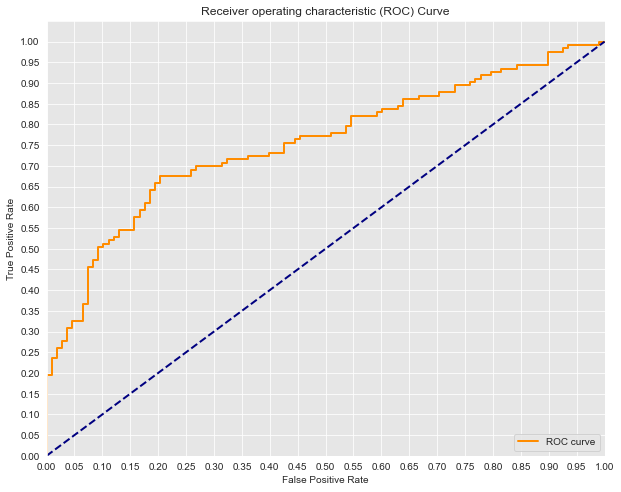

In [27]:
# Generate ROC curve. 

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr_SVM, tpr_SVM)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr_SVM, tpr_SVM, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()